In [1]:
!pip install pytorch-metric-learning
!pip install record_keeper
!pip install faiss

     |████████████████████████████████| 98 kB 1.3 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 4.7 MB 3.0 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
package_paths = [
    '../input/pytorch-image-models/pytorch-image-models-master', #'../input/efficientnet-pytorch-07/efficientnet_pytorch-0.7.0'
    '../input/image-fmix/FMix-master'
]
import sys; 

for pth in package_paths:
    sys.path.append(pth)
    
from fmix import sample_mask, make_low_freq_image, binarise_mask

In [3]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import timm

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

In [4]:
from pytorch_metric_learning import losses, miners, samplers, trainers, testers
from pytorch_metric_learning.utils import common_functions
import pytorch_metric_learning.utils.logging_presets as logging_presets
import numpy as np
import torchvision
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from PIL import Image
import logging
import matplotlib.pyplot as plt
import umap
from cycler import cycler
import record_keeper
import pytorch_metric_learning

In [5]:
CFG = {
    'fold_num': 5,
    'seed': 214,
    'model_arch': 'resnext50_32x4d',
    'img_size': 512,
    'epochs': 10,
    'train_bs': 16,
    'valid_bs': 32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay':1e-6,
    'num_workers': 4,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0',
    'metric_hidden': 256
}

In [6]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [7]:
train.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

> We could do stratified validation split in each fold to make each fold's train and validation set looks like the whole train set in target distributions.

In [8]:
submission = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
submission.head()

image_id  label
0  2216849948.jpg      4

# Helper Functions

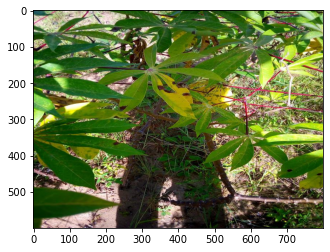

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

img = get_img('../input/cassava-leaf-disease-classification/train_images/1000015157.jpg')
plt.imshow(img)
plt.show()

# Dataset

In [10]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


class CassavaDataset(Dataset):
    def __init__(self, df, data_root, 
                 transforms=None, 
                 output_label=True, 
                 one_hot_label=False,
                 do_fmix=False, 
                 fmix_params={
                     'alpha': 1., 
                     'decay_power': 3., 
                     'shape': (CFG['img_size'], CFG['img_size']),
                     'max_soft': True, 
                     'reformulate': False
                 },
                 do_cutmix=False,
                 cutmix_params={
                     'alpha': 1,
                 }
                ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.do_fmix = do_fmix
        self.fmix_params = fmix_params
        self.do_cutmix = do_cutmix
        self.cutmix_params = cutmix_params
        
        self.output_label = output_label
        self.one_hot_label = one_hot_label
        
        if output_label == True:
            self.labels = self.df['label'].values
            #print(self.labels)
            
            if one_hot_label is True:
                self.labels = np.eye(self.df['label'].max()+1)[self.labels]
                #print(self.labels)
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.labels[index]
          
        img  = get_img("{}/{}".format(self.data_root, self.df.loc[index]['image_id']))

        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.do_fmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            with torch.no_grad():
                #lam, mask = sample_mask(**self.fmix_params)
                
                lam = np.clip(np.random.beta(self.fmix_params['alpha'], self.fmix_params['alpha']),0.6,0.7)
                
                # Make mask, get mean / std
                mask = make_low_freq_image(self.fmix_params['decay_power'], self.fmix_params['shape'])
                mask = binarise_mask(mask, lam, self.fmix_params['shape'], self.fmix_params['max_soft'])
    
                fmix_ix = np.random.choice(self.df.index, size=1)[0]
                fmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[fmix_ix]['image_id']))

                if self.transforms:
                    fmix_img = self.transforms(image=fmix_img)['image']

                mask_torch = torch.from_numpy(mask)
                
                # mix image
                img = mask_torch*img+(1.-mask_torch)*fmix_img

                #print(mask.shape)

                #assert self.output_label==True and self.one_hot_label==True

                # mix target
                rate = mask.sum()/CFG['img_size']/CFG['img_size']
                target = rate*target + (1.-rate)*self.labels[fmix_ix]
                #print(target, mask, img)
                #assert False
        
        if self.do_cutmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            #print(img.sum(), img.shape)
            with torch.no_grad():
                cmix_ix = np.random.choice(self.df.index, size=1)[0]
                cmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[cmix_ix]['image_id']))
                if self.transforms:
                    cmix_img = self.transforms(image=cmix_img)['image']
                    
                lam = np.clip(np.random.beta(self.cutmix_params['alpha'], self.cutmix_params['alpha']),0.3,0.4)
                bbx1, bby1, bbx2, bby2 = rand_bbox((CFG['img_size'], CFG['img_size']), lam)

                img[:, bbx1:bbx2, bby1:bby2] = cmix_img[:, bbx1:bbx2, bby1:bby2]

                rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (CFG['img_size'] * CFG['img_size']))
                target = rate*target + (1.-rate)*self.labels[cmix_ix]
                
            #print('-', img.sum())
            #print(target)
            #assert False
                            
        # do label smoothing
        #print(type(img), type(target))
        if self.output_label == True:
            return img, target
        else:
            return img

# Define Train\Validation Image Augmentations

In [11]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop, RandomSunFlare,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            RandomSunFlare(p=0.5, src_color=[160, 160, 160]),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            OneOf([
                Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.8),
                CoarseDropout(p=0.8),
            ], p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

# Model

In [12]:
class CassvaImgTrunk(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
#         n_features = self.model.classifier.in_features
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG['metric_hidden'])
#         self.model.classifier = nn.Linear(n_features, CFG['metric_hidden'])
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x
    

class CassvaImgEmbedder(nn.Module):
    def __init__(self, num_features):
        super(CassvaImgEmbedder, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dense1 = nn.Linear(num_features, num_features // 2)
        self.relu1 = nn.ReLU()
        
        self.batch_norm2 = nn.BatchNorm1d(num_features // 2)
        self.dropout2 = nn.Dropout(0.3)
        self.dense2 = nn.Linear(num_features // 2, num_features // 4)

    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.relu1(self.dense1(x))
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = self.dense2(x)
        return x   


class CassvaImgClassifier(nn.Module):
    def __init__(self, num_features, n_class, hidden_size):
        super(CassvaImgClassifier, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dense1 = nn.Linear(num_features, hidden_size)
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.3)
        self.dense2 = nn.Linear(hidden_size, int(hidden_size / 2))
        
        self.batch_norm3 = nn.BatchNorm1d(int(hidden_size / 2))
        self.dropout3 = nn.Dropout(0.3)
        self.dense3 = nn.Linear(int(hidden_size / 2), n_class)
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x        
        

# Training APIs

In [13]:
def prepare_dataloader(df, trn_idx, val_idx, data_root='../input/cassava-leaf-disease-classification/train_images/'):
    
    from catalyst.data.sampler import BalanceClassSampler
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
        
    train_ds = CassavaDataset(train_, data_root, transforms=get_train_transforms(), output_label=True, one_hot_label=False, do_fmix=False, do_cutmix=False)
    valid_ds = CassavaDataset(valid_, data_root, transforms=get_valid_transforms(), output_label=True)
    
#     train_loader = torch.utils.data.DataLoader(
#         train_ds,
#         batch_size=CFG['train_bs'],
#         pin_memory=False,
#         drop_last=False,
#         shuffle=True,        
#         num_workers=CFG['num_workers'],
#         #sampler=BalanceClassSampler(labels=train_['label'].values, mode="downsampling")
#     )
#     val_loader = torch.utils.data.DataLoader(
#         valid_ds, 
#         batch_size=CFG['valid_bs'],
#         num_workers=CFG['num_workers'],
#         shuffle=False,
#         pin_memory=False,
#     )
    return train_ds, valid_ds


# Main Loop

Training with 0 started
17117 4280


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnext50_32x4d_ra-d733960d.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d_ra-d733960d.pth
100%|██████████| 134/134 [01:33<00:00,  1.44it/s]


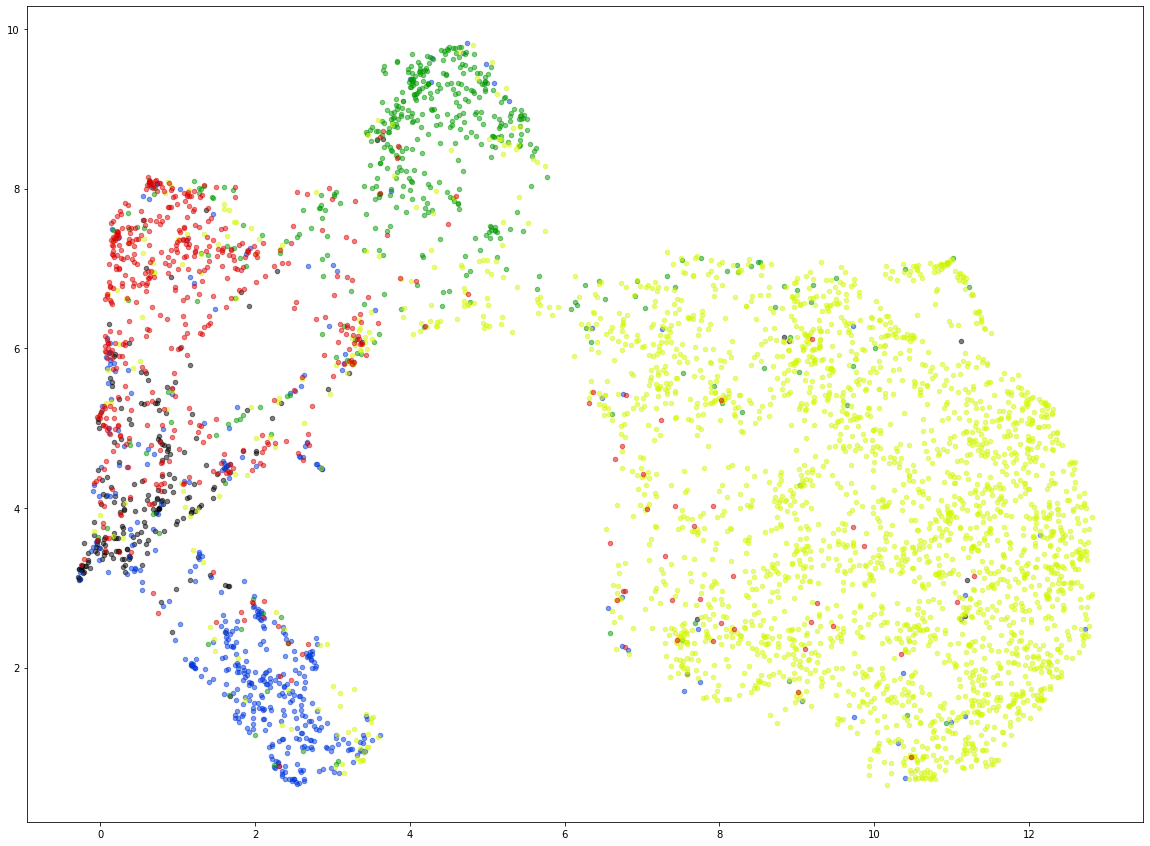

100%|██████████| 134/134 [01:25<00:00,  1.56it/s]


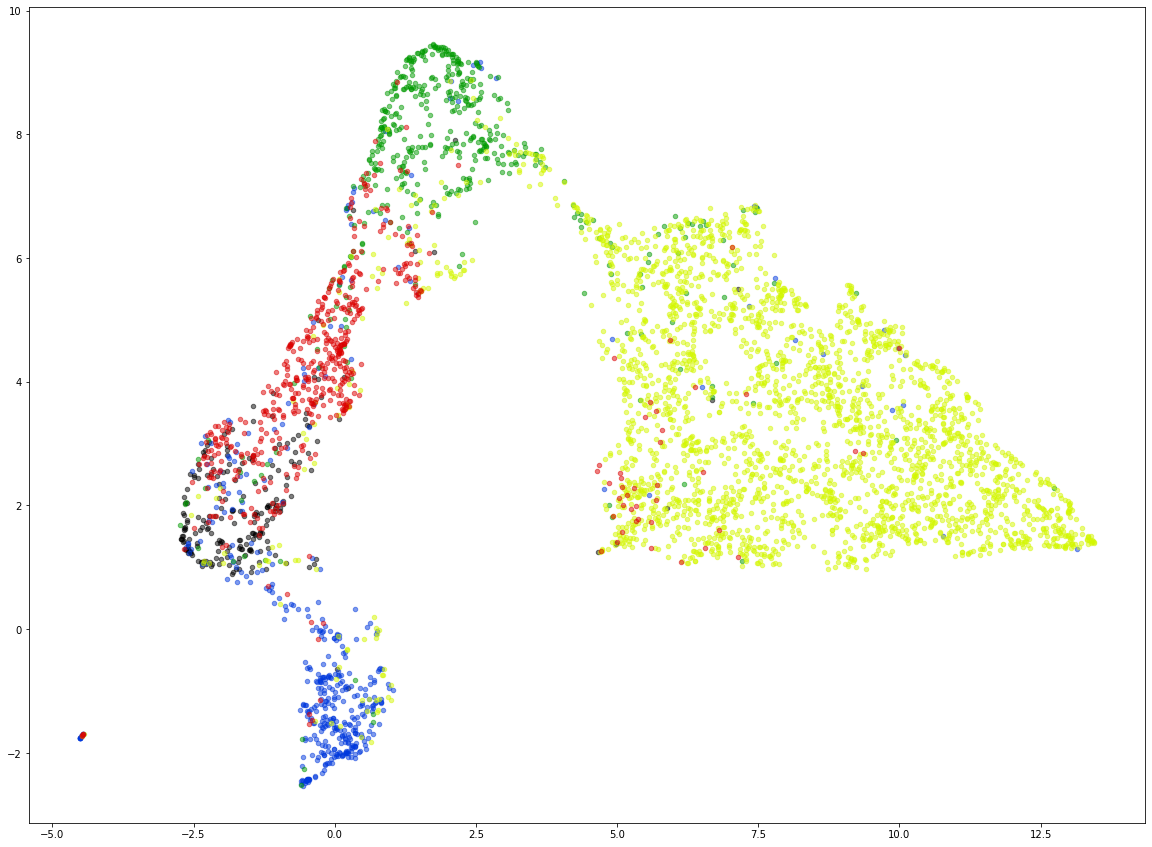

100%|██████████| 134/134 [01:26<00:00,  1.55it/s]


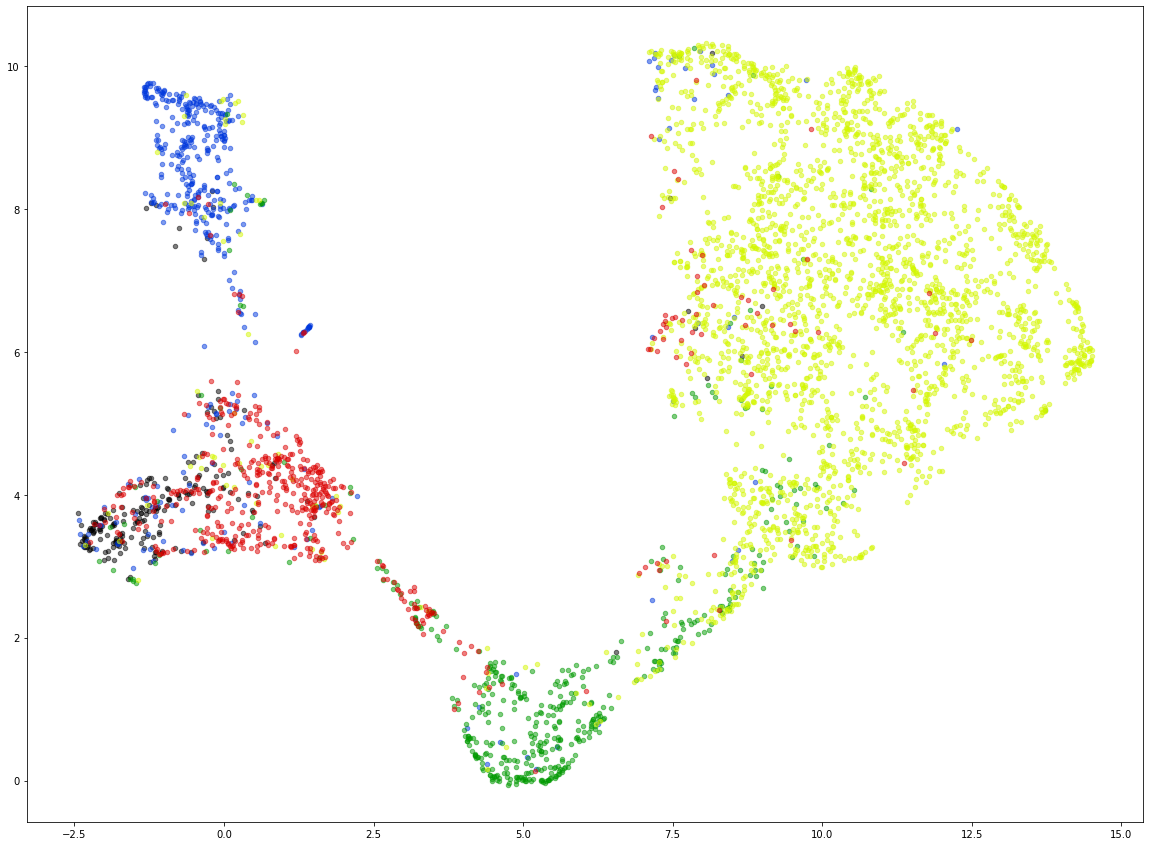

100%|██████████| 134/134 [01:24<00:00,  1.58it/s]


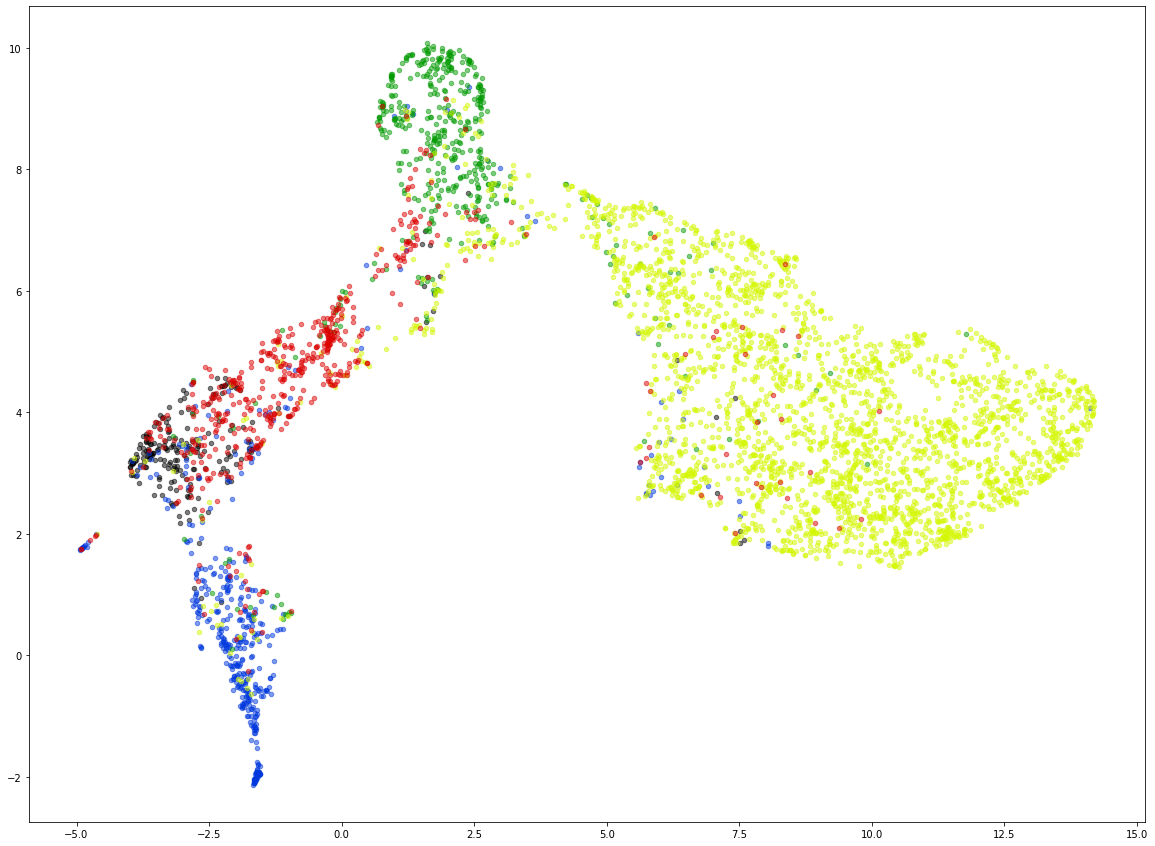

100%|██████████| 134/134 [01:26<00:00,  1.55it/s]


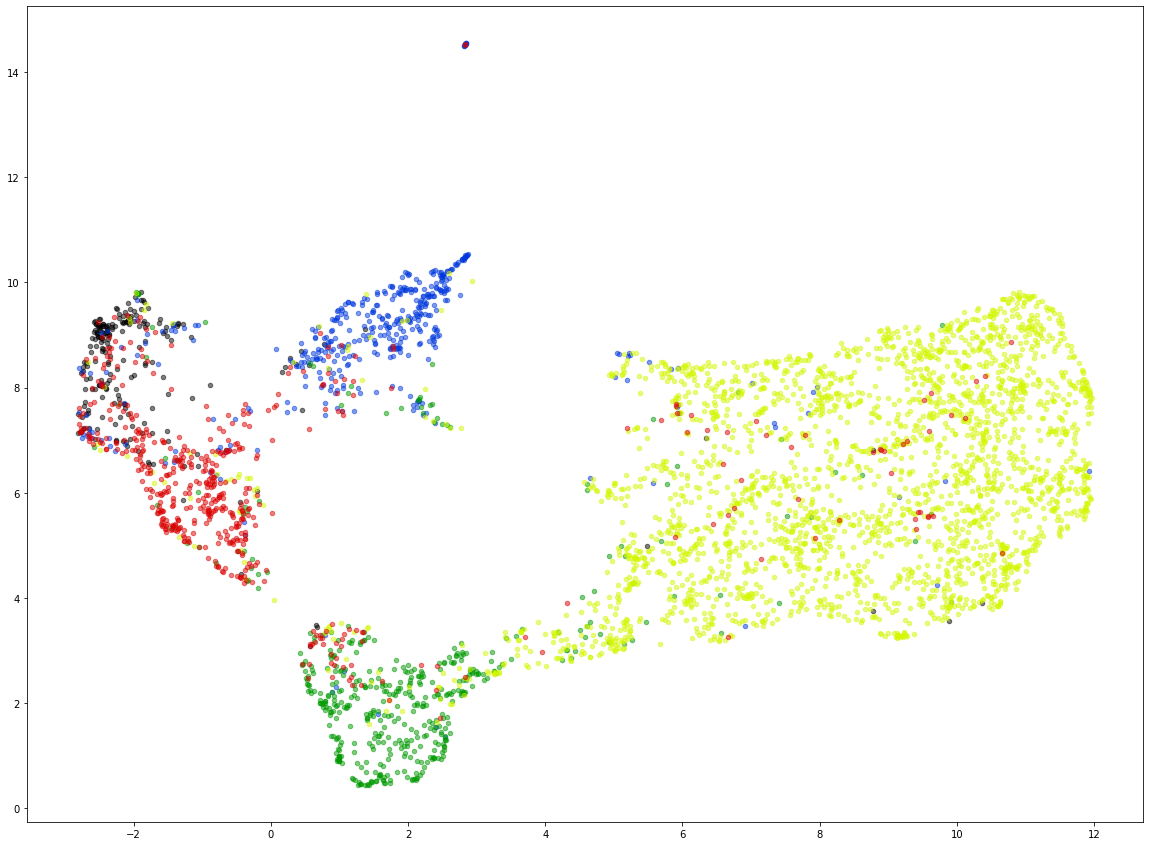

100%|██████████| 134/134 [01:25<00:00,  1.57it/s]


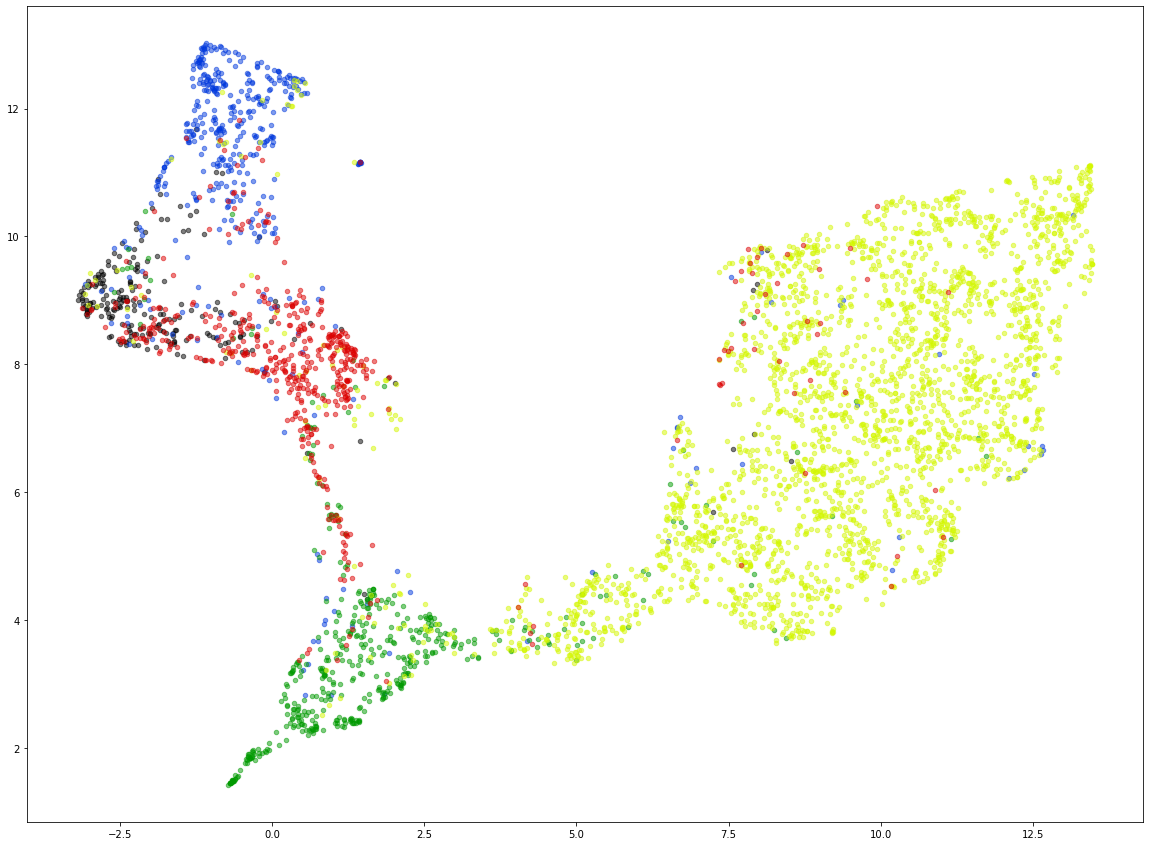

100%|██████████| 134/134 [01:28<00:00,  1.51it/s]


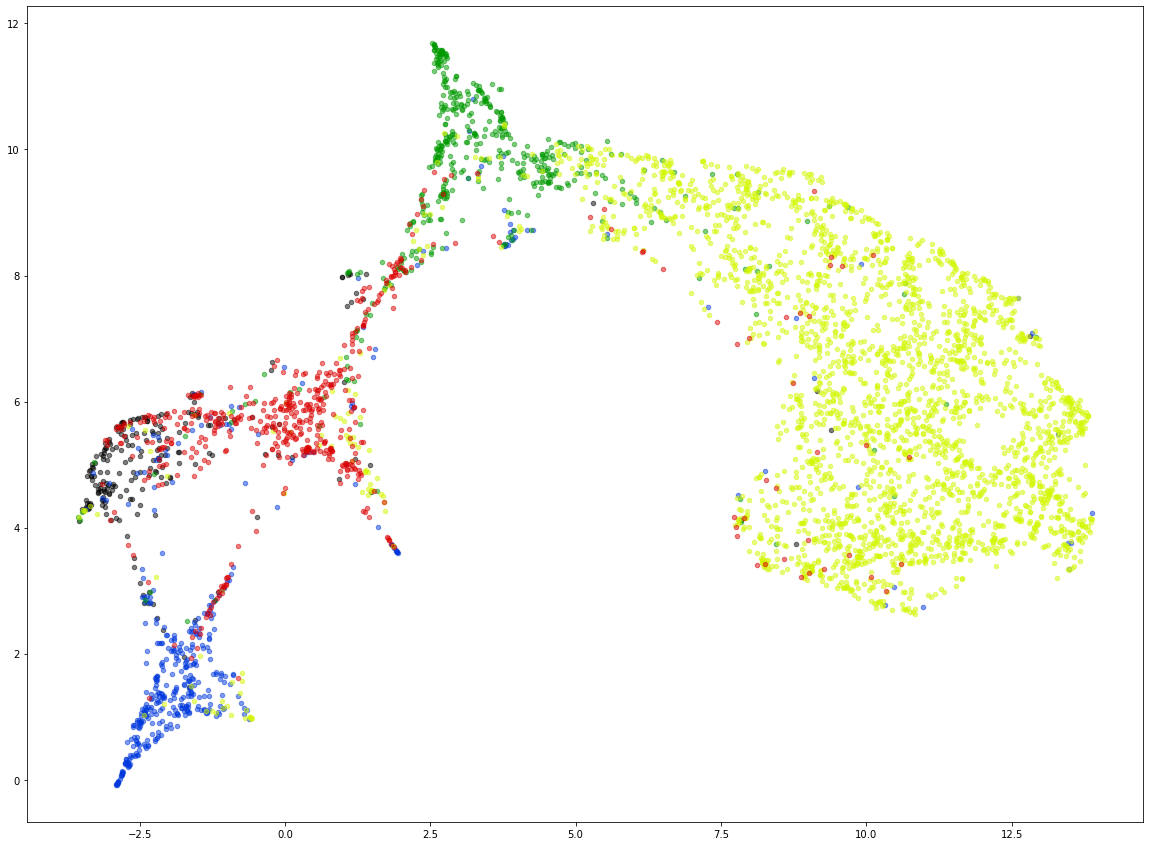

100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


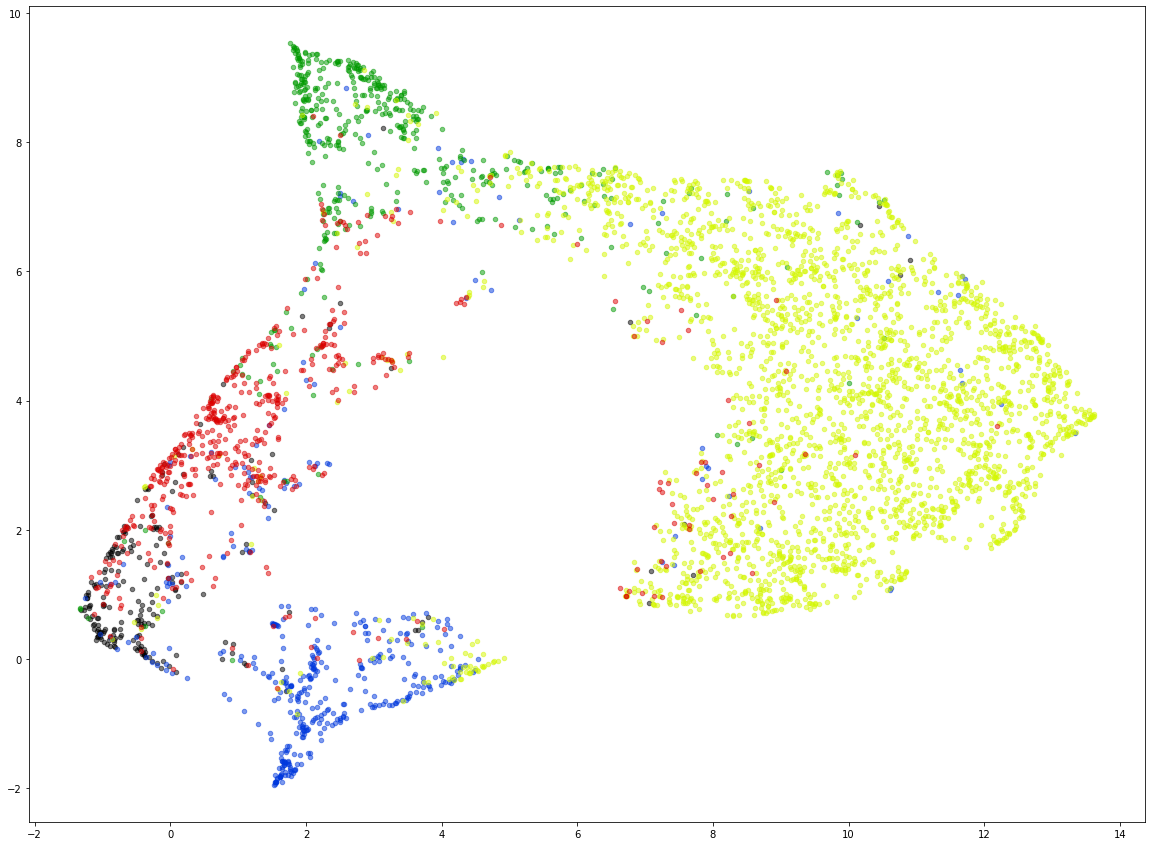

100%|██████████| 134/134 [01:23<00:00,  1.60it/s]


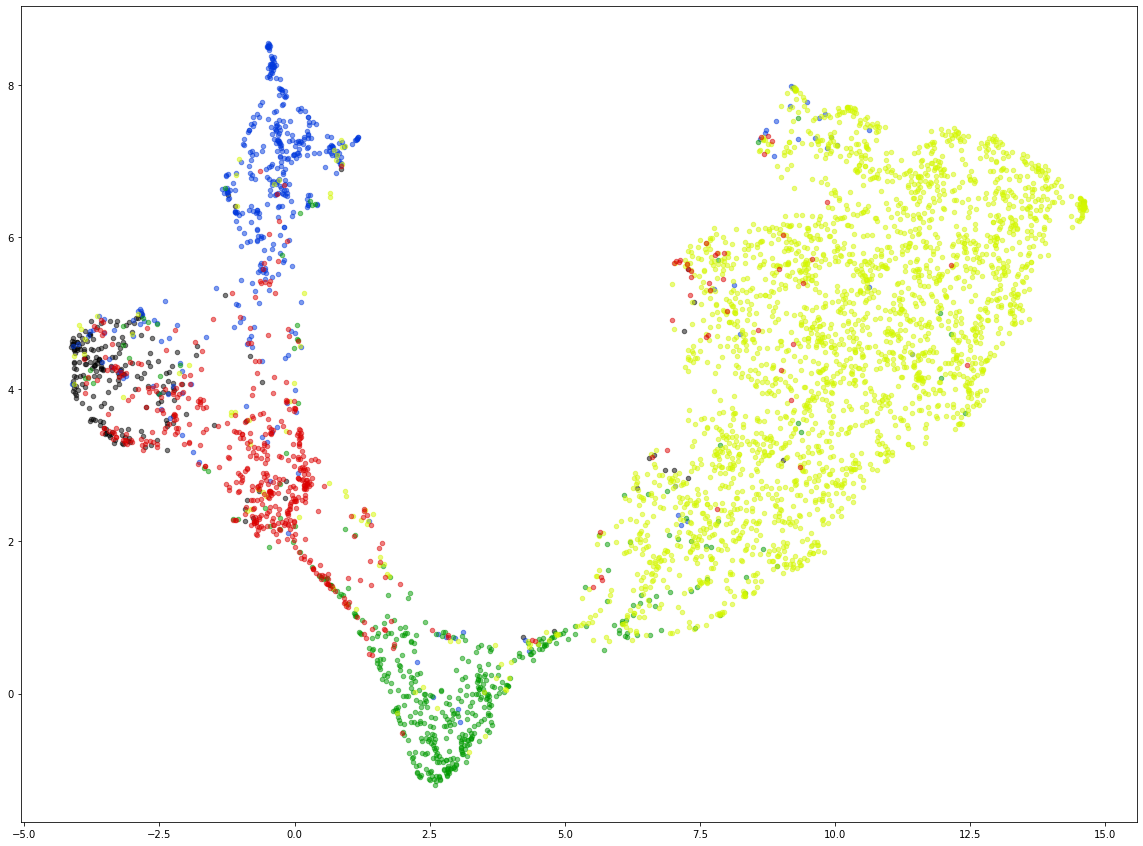

100%|██████████| 134/134 [01:20<00:00,  1.66it/s]


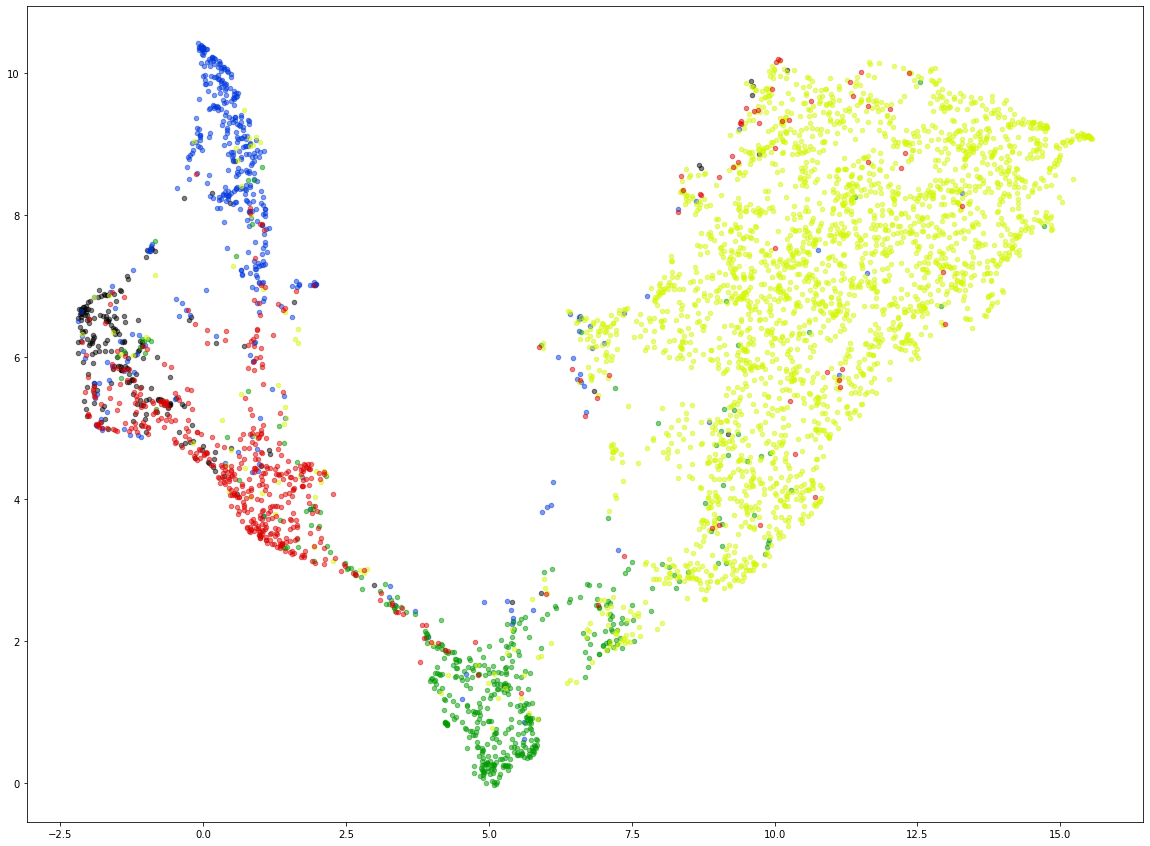

100%|██████████| 134/134 [01:22<00:00,  1.63it/s]


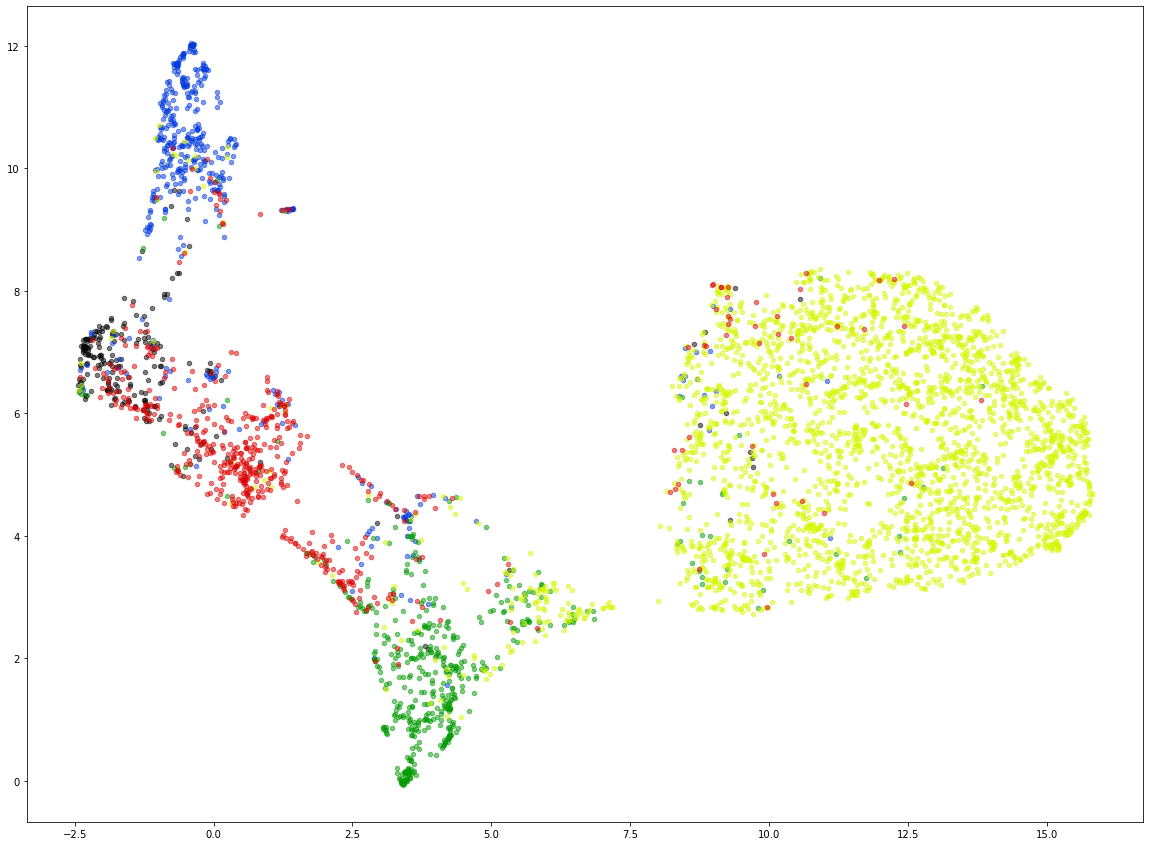

100%|██████████| 134/134 [01:20<00:00,  1.67it/s]


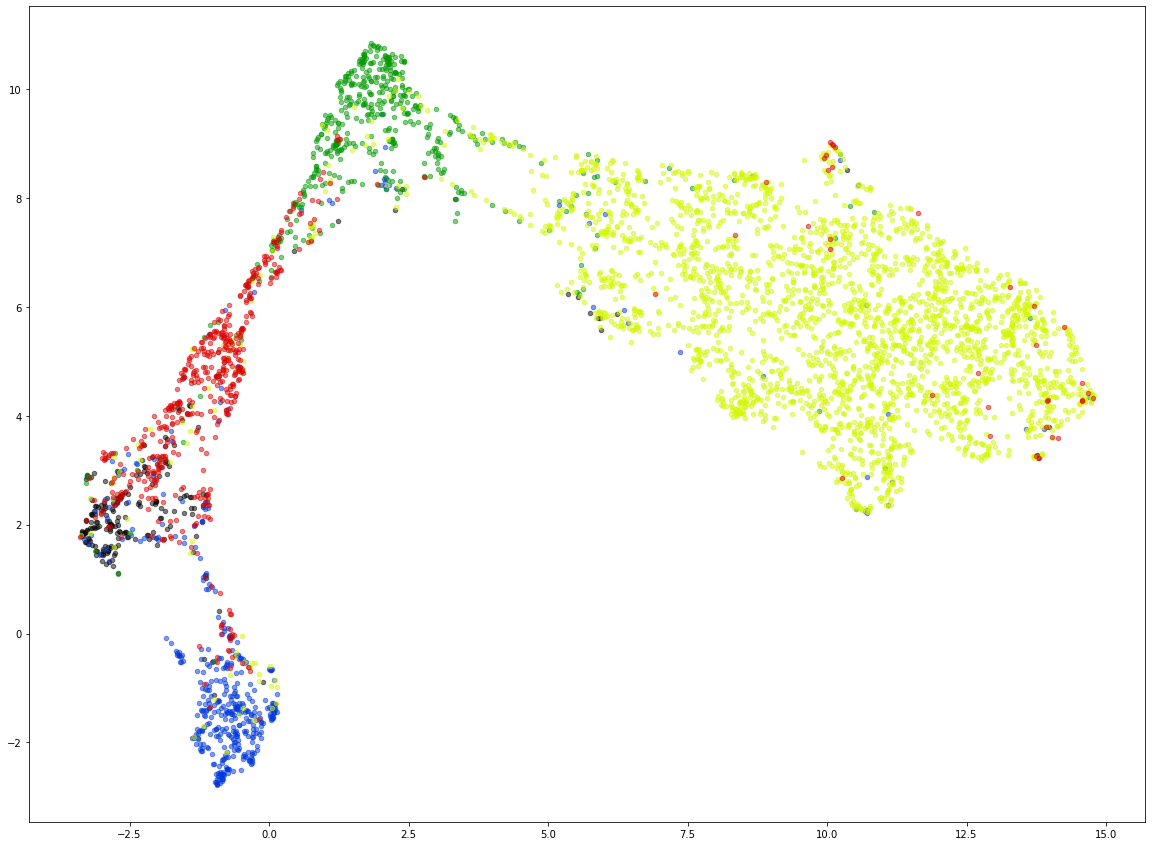

100%|██████████| 134/134 [01:26<00:00,  1.54it/s]


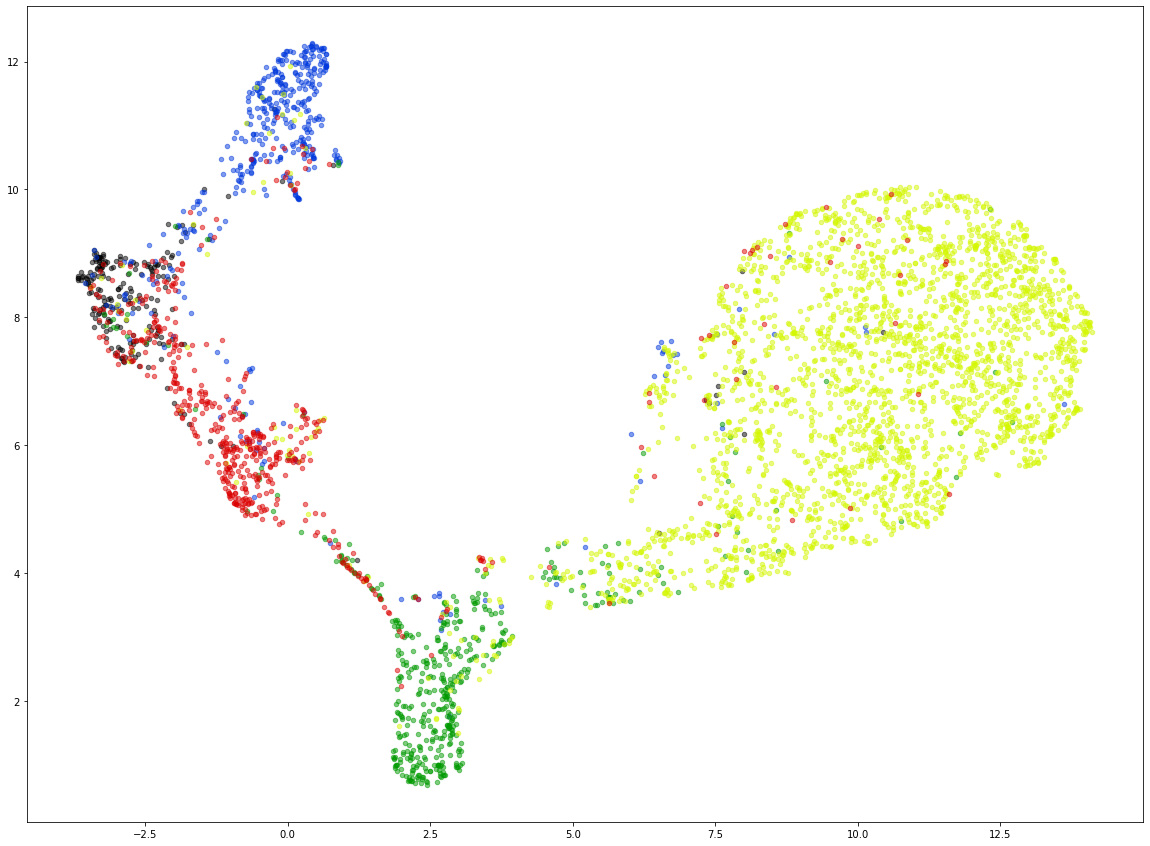

100%|██████████| 134/134 [01:21<00:00,  1.64it/s]


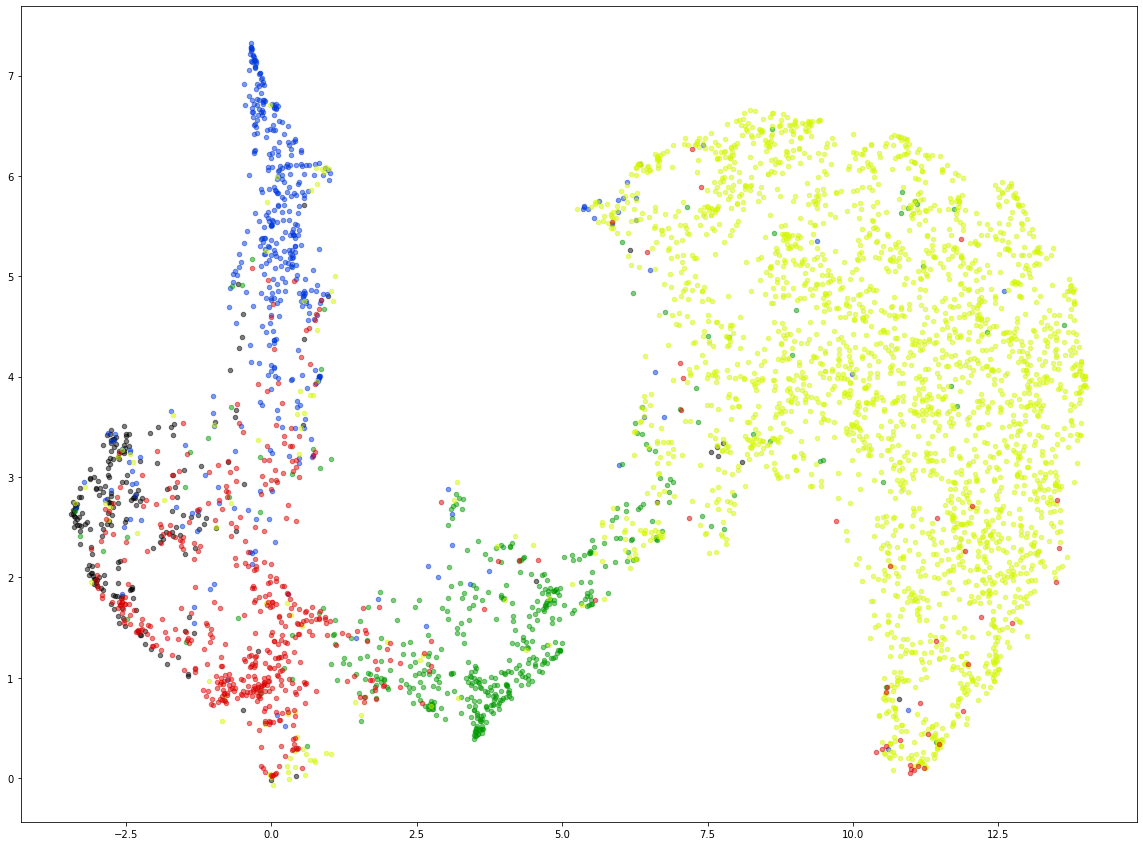

100%|██████████| 134/134 [01:22<00:00,  1.63it/s]


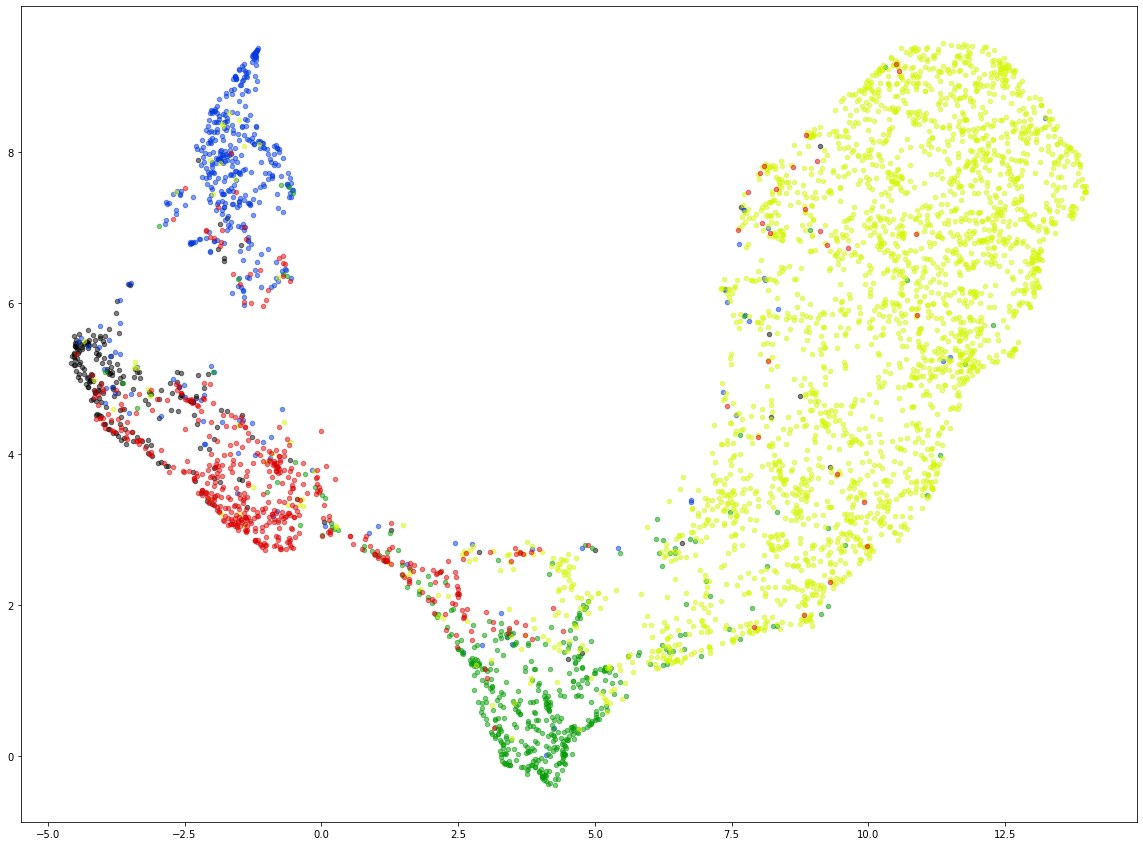

In [14]:
if __name__ == '__main__':
     # for training only, need nightly build pytorch

    seed_everything(CFG['seed'])
    
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
        # we'll train fold 0 first
        if fold > 0:
            break 

        print('Training with {} started'.format(fold))

        print(len(trn_idx), len(val_idx))
        train_dataset, val_dataset = prepare_dataloader(train, trn_idx, val_idx, data_root='../input/cassava-leaf-disease-classification/train_images/')

        device = torch.device(CFG['device'])
        
    
        
        
        # Set trunk model and replace the softmax layer with an identity function
        trunk = CassvaImgTrunk(CFG['model_arch'], train.label.nunique(), pretrained=True).to(device)
        trunk = torch.nn.DataParallel(trunk.to(device))
        
        embedder = torch.nn.DataParallel(CassvaImgEmbedder(256))
        classifier = torch.nn.DataParallel(CassvaImgClassifier(64, 5, 200)).to(device)
        
        trunk_optimizer = torch.optim.Adam(trunk.parameters(), lr=CFG['lr'], weight_decay=0.0001)
        embedder_optimizer = torch.optim.Adam(embedder.parameters(), lr=CFG['lr'], weight_decay=0.0001)
        classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=CFG['lr'], weight_decay=0.0001) 
        
        # Set the loss function
        loss = losses.TripletMarginLoss(margin=0.1)

        # Set the classification loss:
        classification_loss = torch.nn.CrossEntropyLoss()

        # Set the mining function
        miner = miners.MultiSimilarityMiner(epsilon=0.1)

        # Set the dataloader sampler
        sampler = samplers.MPerClassSampler(train_dataset.labels, m=4, length_before_new_iter=len(train_dataset))

        # Set other training parameters
        batch_size = 16
        num_epochs = 15
        
        
        # Package the above stuff into dictionaries.
        models = {"trunk": trunk, "embedder": embedder, "classifier": classifier}
        optimizers = {"trunk_optimizer": trunk_optimizer, "embedder_optimizer": embedder_optimizer, "classifier_optimizer": classifier_optimizer}
        loss_funcs = {"metric_loss": loss, "classifier_loss": classification_loss}
        mining_funcs = {"tuple_miner": miner}

        # We can specify loss weights if we want to. This is optional
        loss_weights = {"metric_loss": 0.5, "classifier_loss": 1}
        
        record_keeper, _, _ = logging_presets.get_record_keeper("example_logs", "example_tensorboard")
        hooks = logging_presets.get_hook_container(record_keeper)
        dataset_dict = {"val": val_dataset}
        model_folder = "output"
        
        def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, *args):
            logging.info("UMAP plot for the {} split and label set {}".format(split_name, keyname))
            label_set = np.unique(labels)
            num_classes = len(label_set)
            fig = plt.figure(figsize=(20,15))
            plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]))
            for i in range(num_classes):
                idx = labels == label_set[i]
                plt.scatter(umap_embeddings[idx, 0], umap_embeddings[idx, 1], s=20, marker="o", alpha=0.5, label=str(i))
            plt.show()

        # Create the tester
        tester = testers.GlobalEmbeddingSpaceTester(end_of_testing_hook = hooks.end_of_testing_hook, 
                                                    visualizer = umap.UMAP(), 
                                                    visualizer_hook = visualizer_hook,
                                                    dataloader_num_workers = 2)

        end_of_epoch_hook = hooks.end_of_epoch_hook(tester, 
                                                    dataset_dict, 
                                                    model_folder, 
                                                    test_interval = 1)
        
        trainer = trainers.TrainWithClassifier(models,
                                        optimizers,
                                        batch_size,
                                        loss_funcs,
                                        mining_funcs,
                                        train_dataset,
                                        sampler=sampler,
                                        dataloader_num_workers = 2,
                                        loss_weights = loss_weights,
                                        end_of_iteration_hook = hooks.end_of_iteration_hook,
                                        end_of_epoch_hook = end_of_epoch_hook)
        

        trainer.train(num_epochs=num_epochs)

# Inferece part is here: https://www.kaggle.com/khyeh0719/pytorch-efficientnet-baseline-inference-tta